In [1]:
!nvidia-smi

Mon Oct  7 14:17:51 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   29C    P0    63W / 500W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   

In [1]:
import sys
# change this to your gigalens direcory
gigalens_path = "/pscratch/sd/f/furcelay/gigalens/src"
sys.path.insert(0, gigalens_path)

import jax
print(jax.devices())

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=2, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=3, process_index=0, slice_index=0)]


In [2]:
from gigalens.jax.inference import ModellingSequence
from gigalens.jax.prob_model import ForwardProbModel, BackwardProbModel
from gigalens.jax.physical_model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.cosmo import Cosmo
from gigalens.jax.profiles import mass, light
from gigalens.jax.prior import Prior, make_prior_and_model

import jax
import optax
from jax import numpy as jnp
import numpy as np

import tensorflow_probability.substrates.jax as tfp
from tensorflow_probability.substrates.jax import distributions as tfd
from corner import corner
import matplotlib.pyplot as plt
import matplotlib as mpl

/global/common/software/deepsrch/jax_gigalens_kernel/jax-gigalens/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Simple example

This is the same as in the original jax-demo.ipynb but with the new way of building the prior that allows fixing some parameters.

To build the prior and the physical model use the `Prior` class with the model and the distribution or constants:

```python
component_prior = Prior(profile, prior_dict)
```

you can fix parameters by using floats instead of distributions on the `prior_dict`

In [5]:
epl_prior = Prior(
            mass.epl.EPL(), # the profile
            dict(  # the prior
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=0.1,  # the position is fixed
                center_y=0.0,
            )
)
shear_prior = Prior(
            mass.shear.Shear(),
            dict(gamma1=tfd.Normal(0, 0.05), 
                 gamma2=tfd.Normal(0, 0.05)
                )
)
lens_light_prior = Prior(
            light.sersic.SersicEllipse(),
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=0.1,
                center_y=0.0,
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
)

source_light_prior = Prior(
            light.sersic.SersicEllipse(),
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
                z_source=1.2 # we must set the redshift on the nersc-cosmo branch (not needed on the nersc branch)
            )
)

In the nersc-cosmo branch you also must set the cosmology  (not needed on the nersc branch), for this example it is just fixed. Note that you must guive the redshifts for the source and the lens, but they do not have any effect unless there are multiple sources.

In [6]:
cosmo_prior = Prior(
        Cosmo(z_lens=0.4, z_source_ref=1.2),  # you need to set the redshifts for the cosmology to work, theta_E is relative to z_source_ref
    dict(
        H0=70.,
        Om0=0.3,
        w0=-1.0,
        wa=0.0,
        k=0.0,
    )
)

Then we build both the prior and the physical model with `make_prior_and_model`, it will rise an error if a parameter is missing

In [7]:
prior, phys_model = make_prior_and_model(
    lenses=[
        epl_prior,
        shear_prior,
    ],
    sources=[
        source_light_prior
    ],
    foreground=[
        lens_light_prior
    ],
    cosmo=cosmo_prior
)

set everything else as usual

In [8]:
kernel = np.load(f'{gigalens_path}/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
observed_img = np.load(f'{gigalens_path}/gigalens/assets/demo.npy')

In [48]:
background_rms = 0.2
exp_time = 100

for the forward prob model you need to set which constraints you want (positions and/or pixels)

In [49]:
prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time, 
                              include_pixels=True, include_positions=False)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

For the MAP stage the best model is computed internally

In [50]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-2/3, 
                                      power=0.5, transition_steps=500)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
best_model, best_chi2 = model_seq.MAP(opt, seed=0)

Chi-squared: 0.986: 100%|██████████| 350/350 [00:11<00:00, 29.46it/s]


The model parameters are stored in dictionaries instead of lists, this allows fixing a component

In [51]:
best_model

{'source_light': {'0': {'n_sersic': Array([1.7545767], dtype=float32),
   'e2': Array([0.00220916], dtype=float32),
   'e1': Array([0.0090245], dtype=float32),
   'center_y': Array([-0.05756541], dtype=float32),
   'center_x': Array([0.09601775], dtype=float32),
   'R_sersic': Array([0.2582779], dtype=float32),
   'Ie': Array([119.45548], dtype=float32)}},
 'lens_mass': {'1': {'gamma2': Array([0.03646934], dtype=float32),
   'gamma1': Array([-0.00585525], dtype=float32)},
  '0': {'theta_E': Array([1.1001796], dtype=float32),
   'gamma': Array([1.9107893], dtype=float32),
   'e2': Array([0.0977926], dtype=float32),
   'e1': Array([0.08618449], dtype=float32)}},
 'lens_light': {'0': {'n_sersic': Array([2.609399], dtype=float32),
   'e2': Array([0.14892553], dtype=float32),
   'e1': Array([0.09292698], dtype=float32),
   'R_sersic': Array([0.8119316], dtype=float32),
   'Ie': Array([476.5454], dtype=float32)}}}

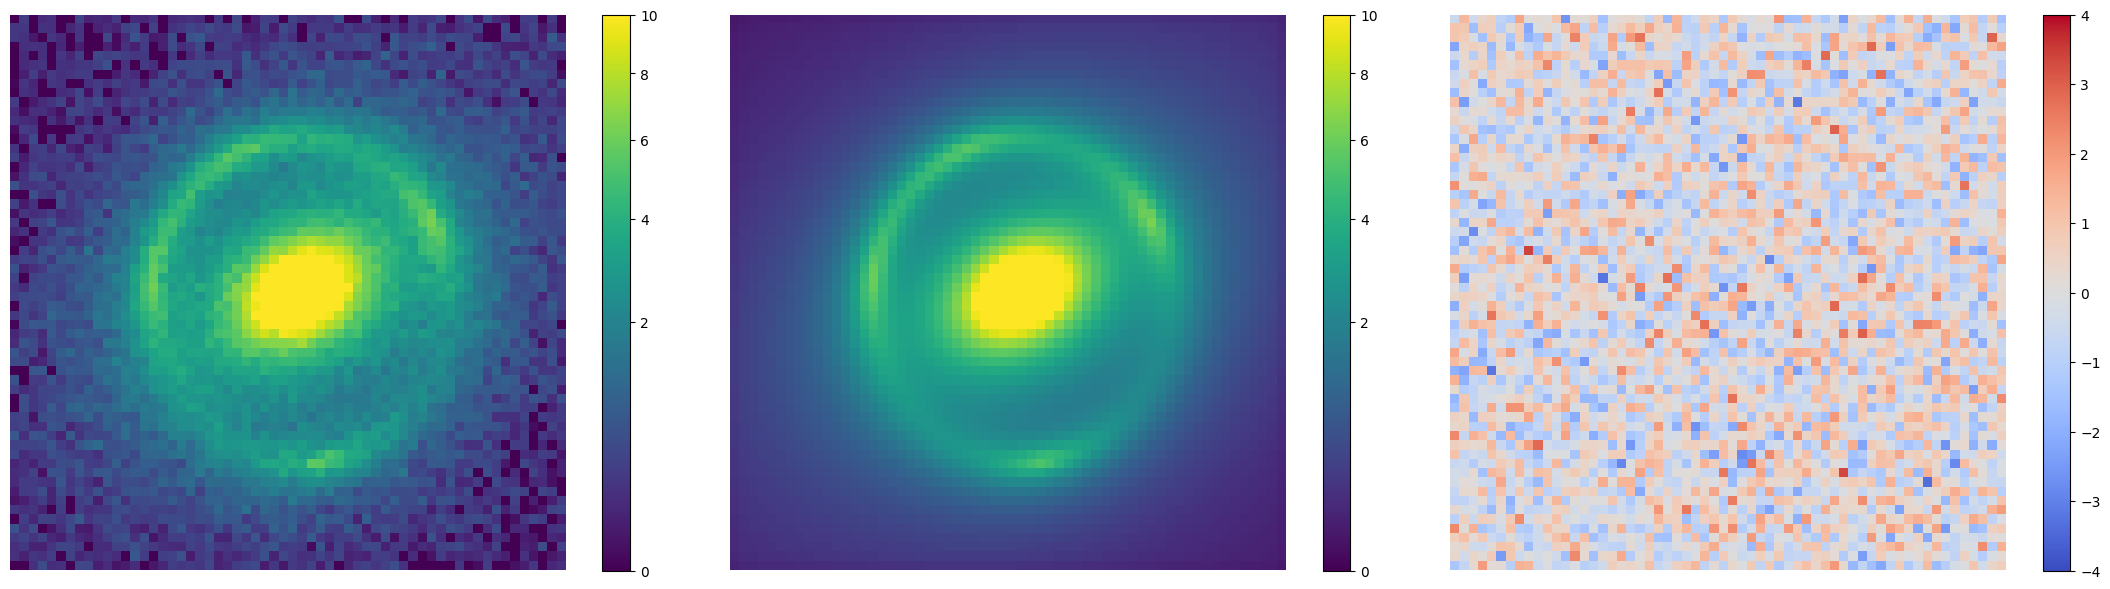

In [52]:
simulator = LensSimulator(phys_model, sim_config, bs=1)
simulated = simulator.simulate(best_model)

plt.figure(figsize=(22, 6))

plt.subplot(131)
plt.imshow(observed_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=10), origin="lower")
plt.colorbar()
plt.axis('off')

plt.subplot(132)
plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=10), origin="lower")
plt.colorbar()
plt.axis('off')

plt.subplot(133)
resid = observed_img - simulated
err_map = np.sqrt(simulated / exp_time + background_rms**2)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-4, vmax=4, origin="lower")
plt.colorbar()
plt.axis('off')

plt.tight_layout()

plt.show()

In [53]:
best_z = jnp.stack(prob_model.bij.inverse(best_model), axis=-1)

In [54]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                      power=2, transition_steps=300)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
qz, loss_hist = model_seq.SVI(best_z, opt, n_vi=1000, num_steps=1500)

ELBO: -90.462: 100%|██████████| 1500/1500 [00:53<00:00, 28.12it/s]


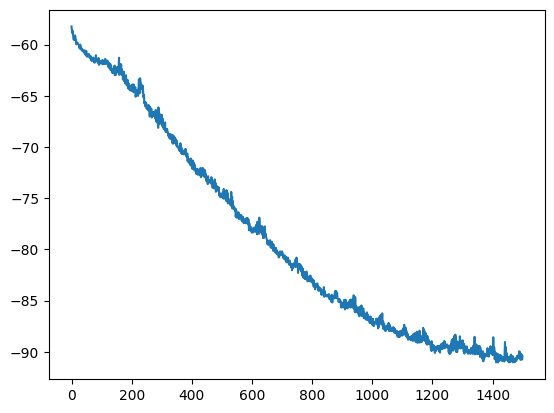

In [55]:
plt.plot(loss_hist)
plt.show()

In [56]:
samples_z = model_seq.HMC(qz, num_burnin_steps=250, num_results=750).all_states

Sampling took 42.7s


In [61]:
samples = prob_model.bij.forward(list(samples_z.T))

In [64]:
packed_samples = jnp.stack(prob_model.pack_bij.inverse(samples), axis=-1)

In [68]:
rhat = tfp.mcmc.potential_scale_reduction(jnp.transpose(packed_samples, (1,2,0,3)), independent_chain_ndims=2)
rhat = prob_model.pack_bij.forward(list(rhat.T))

In [69]:
rhat

{'source_light': {'0': {'n_sersic': Array(1.0060673, dtype=float32),
   'e2': Array(1.0003407, dtype=float32),
   'e1': Array(1.0003684, dtype=float32),
   'center_y': Array(1.013638, dtype=float32),
   'center_x': Array(1.0000036, dtype=float32),
   'R_sersic': Array(1.0036398, dtype=float32),
   'Ie': Array(1.0055494, dtype=float32)}},
 'lens_mass': {'1': {'gamma2': Array(1.0080553, dtype=float32),
   'gamma1': Array(1.0070302, dtype=float32)},
  '0': {'theta_E': Array(1.0006466, dtype=float32),
   'gamma': Array(1.0133084, dtype=float32),
   'e2': Array(1.00418, dtype=float32),
   'e1': Array(1.0089349, dtype=float32)}},
 'lens_light': {'0': {'n_sersic': Array(0.99970955, dtype=float32),
   'e2': Array(1.0001608, dtype=float32),
   'e1': Array(1.000907, dtype=float32),
   'R_sersic': Array(1.0004345, dtype=float32),
   'Ie': Array(0.99987036, dtype=float32)}}}

# Sequential Monte Carlo

This is another sampler that replaces the hole pipeline, it still under testing and by now it does not include preconditioning

It runs a set of particles, each particle is a HMC chain, in each step the particles evolve and then are resampled. Also includes annealing to slowly transition from the prior to the posterior. It requires more particles than HMC, also it can run multiple independent ensembles of particles.

In [73]:
# run SMC with two ensembles of 200 particles, then keep sampling HMC for 100 steps
smc_samples_z, smc_best_model_z = model_seq.SMC(
            start=None,
            num_particles=200,        # particles in each ensemble 
            num_ensembles=jax.device_count(),  # ensembles, can be splitted in the GPUs
            num_leapfrog_steps=10,    # leapfrog on HMC
            post_sampling_steps=100,  # normal HMC steps
            ess_threshold_ratio=0.5,  # ESS threshold for resampling, higher is better but more expensive
            max_sampling_per_stage=8, # maximum resampling steps in each stage
            sampler='HMC',            # sampler HMC or RWMC (only good for positions sampling)
            seed=1)

starting SMC


/global/common/software/deepsrch/jax_gigalens_kernel/jax-gigalens/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:282: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


SMC completed, time: 0.6 min
starting MCMC sampling
MCMC completed, time: 0.5 min


In [74]:
smc_samples = prob_model.bij.forward(list(smc_samples_z.T))
smc_best_model = prob_model.bij.forward(list(smc_best_model_z.T))

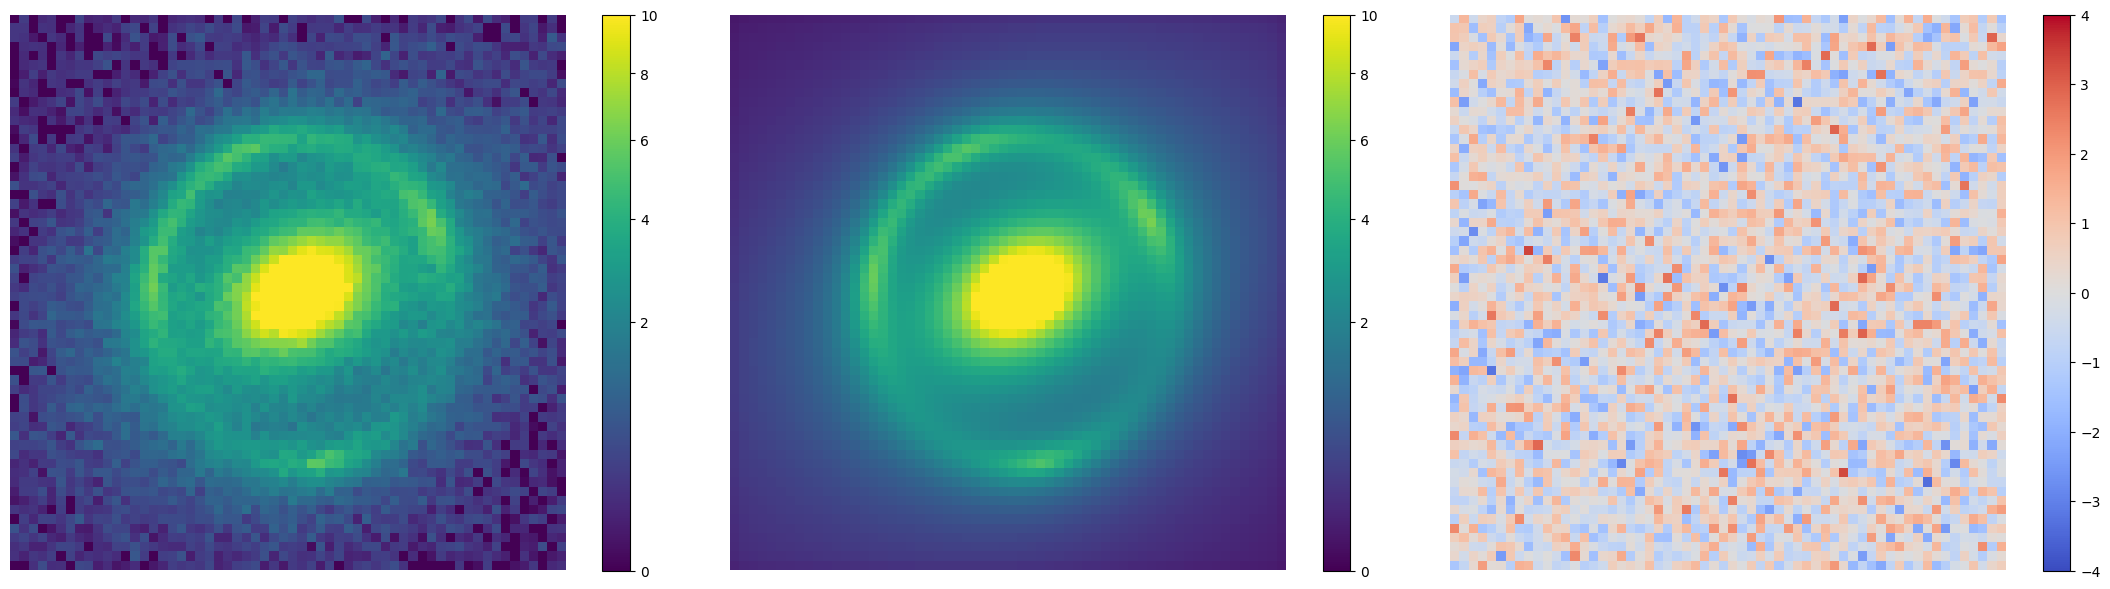

In [75]:
simulator = LensSimulator(phys_model, sim_config, bs=1)
simulated = simulator.simulate(smc_best_model)

plt.figure(figsize=(22, 6))

plt.subplot(131)
plt.imshow(observed_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=10), origin="lower")
plt.colorbar()
plt.axis('off')

plt.subplot(132)
plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=10), origin="lower")
plt.colorbar()
plt.axis('off')

plt.subplot(133)
resid = observed_img - simulated
err_map = np.sqrt(simulated / exp_time + background_rms**2)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-4, vmax=4, origin="lower")
plt.colorbar()
plt.axis('off')

plt.tight_layout()

plt.show()

In [76]:
packed_samples = jnp.stack(prob_model.pack_bij.inverse(smc_samples), axis=-1)

In [78]:
packed_samples.shape  # shape is (particles * ensembles, samples, parameters)

(800, 100, 18)

In [81]:
rhat = tfp.mcmc.potential_scale_reduction(packed_samples, independent_chain_ndims=1)
rhat = prob_model.pack_bij.forward(list(rhat.T))

In [82]:
rhat

{'source_light': {'0': {'n_sersic': Array(0.9991789, dtype=float32),
   'e2': Array(0.999244, dtype=float32),
   'e1': Array(0.9998822, dtype=float32),
   'center_y': Array(0.99978447, dtype=float32),
   'center_x': Array(0.99964213, dtype=float32),
   'R_sersic': Array(1.0000665, dtype=float32),
   'Ie': Array(0.9991578, dtype=float32)}},
 'lens_mass': {'1': {'gamma2': Array(0.9999285, dtype=float32),
   'gamma1': Array(0.9999435, dtype=float32)},
  '0': {'theta_E': Array(0.99962664, dtype=float32),
   'gamma': Array(0.99990785, dtype=float32),
   'e2': Array(0.99947655, dtype=float32),
   'e1': Array(0.9995905, dtype=float32)}},
 'lens_light': {'0': {'n_sersic': Array(0.9992789, dtype=float32),
   'e2': Array(0.999758, dtype=float32),
   'e1': Array(0.99935424, dtype=float32),
   'R_sersic': Array(0.99906766, dtype=float32),
   'Ie': Array(0.9991522, dtype=float32)}}}

# Shapelets and Backward prob model

Same as in shapelets-demo.ipynb

first we simulate the system

/tmp/ipykernel_433609/3546132184.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol, resid, _, _ = np.linalg.lstsq(X.T, Y)


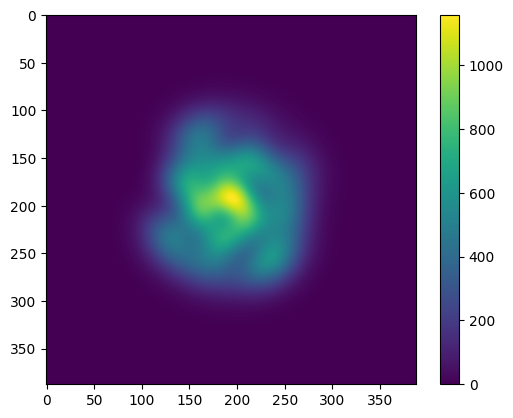

In [3]:
img = plt.imread(f'{gigalens_path}/gigalens/assets/M101.jpeg')
img = img[:,131:-131]
img = np.sqrt(img[...,1].astype(np.float32))
img -= np.median(img[:20,:20])
img *= 100
from skimage.transform import downscale_local_mean
img = downscale_local_mean(img, (5,5))
img = np.pad(img, [(100, 100), (100, 100)], mode='constant')
grid = np.linspace(-1,1,len(img)).astype(np.float32)
xx,yy = np.meshgrid(grid,grid)
xx, yy = xx[np.newaxis,...,np.newaxis], yy[np.newaxis,...,np.newaxis]
n_max = 8
shp = light.shapelets.Shapelets(n_max=n_max, interpolate=False, use_lstsq=True)
components = np.squeeze(shp.light(xx, yy, beta=0.13, center_x=0, center_y=0))
X = components.reshape((shp.depth, -1))
Y = img.flatten()
sol, resid, _, _ = np.linalg.lstsq(X.T, Y)
plt.imshow((sol@X).reshape(img.shape))
plt.colorbar()
plt.show()

In [4]:
epl_prior = Prior(
            mass.epl.EPL(), # the profile
            dict(  # the prior
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=0.1,  # the position is fixed
                center_y=0.0,
            )
)
shear_prior = Prior(
            mass.shear.Shear(),
            dict(gamma1=tfd.Normal(0, 0.05), 
                 gamma2=tfd.Normal(0, 0.05)
                )
)
lens_light_prior = Prior(
            light.sersic.SersicEllipse(use_lstsq=True),
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=0.1,
                center_y=0.0,
            )
)

shapelets_source_prior = Prior(
            light.shapelets.Shapelets(n_max=8, use_lstsq=True),
            dict(
                beta=tfd.LogNormal(jnp.log(0.1), 0.15),
                center_x=tfd.Normal(0, 0.01),
                center_y=tfd.Normal(0, 0.01),
                z_source=1.2
            )
)
cosmo_prior = Prior(
        Cosmo(z_lens=0.4, z_source_ref=1.2),  # you need to set the redshifts for the cosmology to work, theta_E is relative to z_source_ref
    dict(
        H0=70.,
        Om0=0.3,
        w0=-1.0,
        wa=0.0,
        k=0.0,
    )
)

In [5]:
prior, phys_model = make_prior_and_model(
    lenses=[
        epl_prior,
        shear_prior,
    ],
    sources=[
        shapelets_source_prior
    ],
    foreground=[
        lens_light_prior
    ],
    cosmo=cosmo_prior
)

In [6]:
kernel = np.load(f'{gigalens_path}/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

In [7]:
background_rms=0.1
exp_time=200

In [8]:
# set the truth to simulate

truth = prior.sample(1, jax.random.PRNGKey(0))
truth['source_light']['0'] |= {f'amp{str(i).zfill(2)}': jnp.array([sol[i]]) for i in range(shp.depth)}
truth['lens_light']['0']['Ie'] = 20.0

In [9]:
phys_model_true = PhysicalModel(
    lenses=phys_model.lenses,
    source_light=[light.shapelets.Shapelets(n_max=8, use_lstsq=False)],
    lens_light=[light.sersic.SersicEllipse(use_lstsq=False)],
    cosmo=phys_model.cosmo,
    constants=phys_model._constants
)

In [10]:
truth_sim = LensSimulator(phys_model_true, sim_config, bs=1)
simulated = truth_sim.simulate(truth)
err_map = np.sqrt(background_rms**2 + np.clip(simulated, 0, np.inf)/exp_time)
np.random.seed(1)
observed_img = simulated + np.random.normal(scale=err_map)

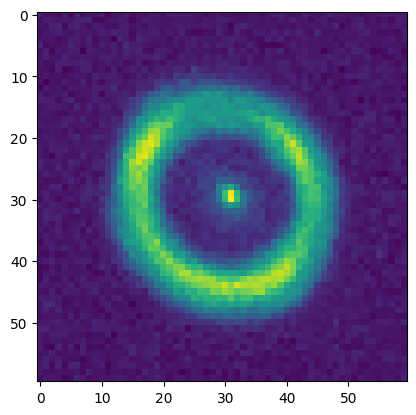

In [11]:
plt.imshow(observed_img)
plt.show()

then we model it

In [12]:
prob_model = BackwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time, include_positions=False)

In [13]:
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [14]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-2/3, 
                                      power=0.5, transition_steps=500)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
best_model, best_chi2 = model_seq.MAP(opt, seed=0)

Chi-squared: 0.966: 100%|██████████| 350/350 [03:07<00:00,  1.87it/s]


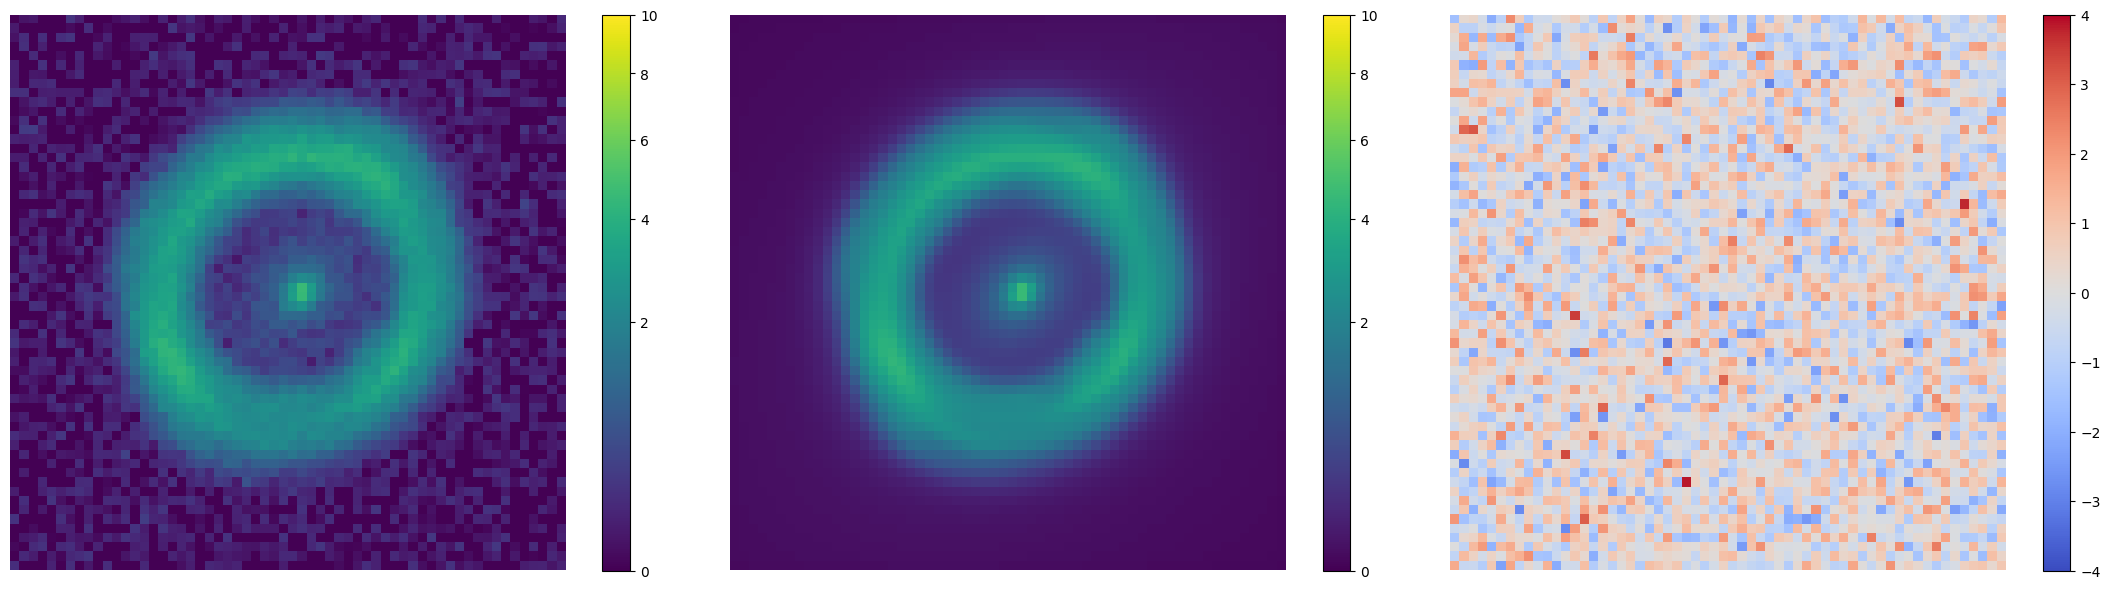

In [16]:
simulator = LensSimulator(phys_model, sim_config, bs=1)
simulated = simulator.lstsq_simulate(best_model, observed_img, prob_model.error_map)

plt.figure(figsize=(22, 6))

plt.subplot(131)
plt.imshow(observed_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=10), origin="lower")
plt.colorbar()
plt.axis('off')

plt.subplot(132)
plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=10), origin="lower")
plt.colorbar()
plt.axis('off')

plt.subplot(133)
resid = observed_img - simulated
err_map = np.sqrt(simulated / exp_time + background_rms**2)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-4, vmax=4, origin="lower")
plt.colorbar()
plt.axis('off')

plt.tight_layout()

plt.show()

# Multiple sources and cosmology

In [19]:
z_lens = 0.4
z_s1 = 1.2
z_s2_truth = 2.3  # we want to recover it
Om0_truth = 0.3
w0_truth = -1.0

In [20]:
epl_prior = Prior(
            mass.epl.EPL(), # the profile
            dict(  # the prior
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=0.1,  # the position is fixed
                center_y=0.0,
            )
)
shear_prior = Prior(
            mass.shear.Shear(),
            dict(gamma1=tfd.Normal(0, 0.05), 
                 gamma2=tfd.Normal(0, 0.05)
                )
)
lens_light_prior = Prior(
            light.sersic.SersicEllipse(),
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=0.1,
                center_y=0.0,
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
)

source_1_prior = Prior(
            light.sersic.SersicEllipse(),
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
                z_source=z_s1
            )
)
source_2_prior = Prior(
            light.sersic.SersicEllipse(),
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
                z_source=tfd.Uniform(1.2, 3.5)  # unknown redshift
            )
)
cosmo_prior = Prior(
        Cosmo(z_lens=z_lens, z_source_ref=z_s1),  # you need to set the redshifts for the cosmology to work, theta_E is relative to z_source_ref
    dict(
        H0=70.,
        Om0=tfd.Uniform(0.01, 0.99),  # free
        w0=tfd.Uniform(-2, -1/3),  # free
        wa=0.0,
        k=0.0,
    )
)

In [21]:
prior, phys_model = make_prior_and_model(
    lenses=[
        epl_prior,
        shear_prior,
    ],
    sources=[
        source_1_prior,
        source_2_prior
    ],
    foreground=[
        lens_light_prior
    ],
    cosmo=cosmo_prior
)

In [22]:
# set the truth to simulate

truth = prior.sample(1, jax.random.PRNGKey(0))
truth['source_light']['1']['z_source'] = z_s2_truth
truth['cosmo']['Om0'] = Om0_truth
truth['cosmo']['w0'] = w0_truth

In [25]:
background_rms=0.1
exp_time=200

kernel = np.load(f'{gigalens_path}/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

In [26]:
truth_sim = LensSimulator(phys_model, sim_config, bs=1)
simulated = truth_sim.simulate(truth)
err_map = np.sqrt(background_rms**2 + np.clip(simulated, 0, np.inf)/exp_time)
np.random.seed(1)
observed_img = simulated + np.random.normal(scale=err_map)

the image has two different rings

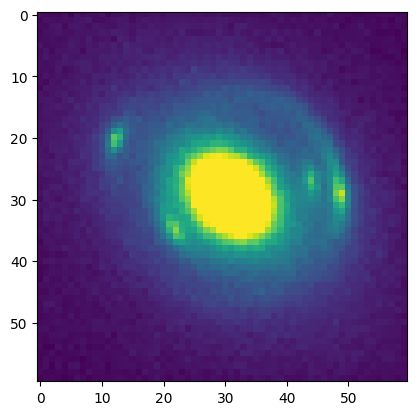

In [28]:
plt.imshow(observed_img, vmax=10)
plt.show()

In [29]:
prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time, 
                              include_pixels=True, include_positions=False)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [30]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-2/3, 
                                      power=0.5, transition_steps=500)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
best_model, best_chi2 = model_seq.MAP(opt, seed=0)

Chi-squared: 1.039: 100%|██████████| 350/350 [00:21<00:00, 16.10it/s] 


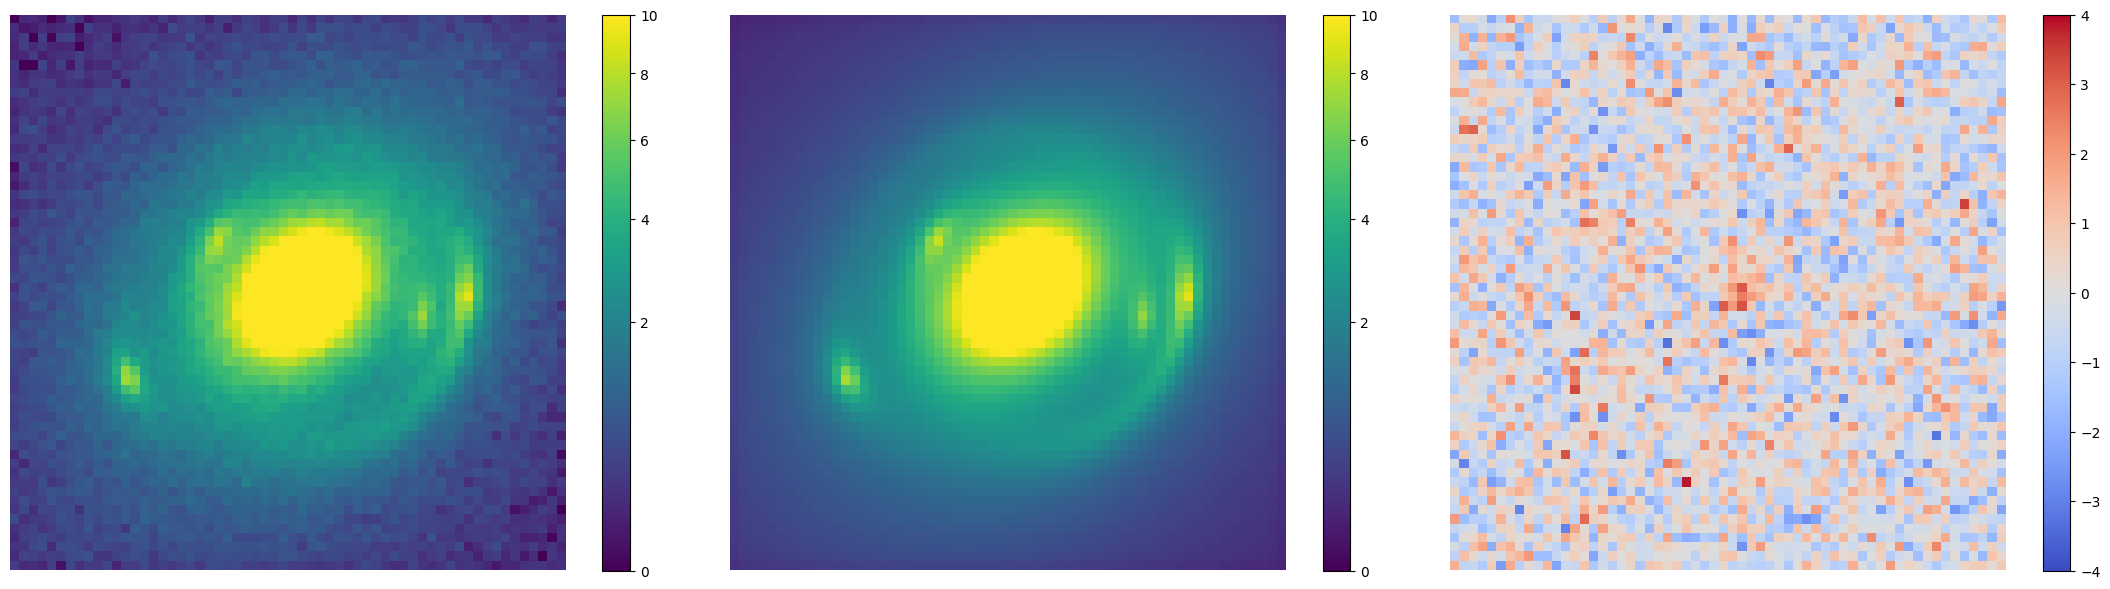

In [31]:
simulator = LensSimulator(phys_model, sim_config, bs=1)
simulated = simulator.simulate(best_model)

plt.figure(figsize=(22, 6))

plt.subplot(131)
plt.imshow(observed_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=10), origin="lower")
plt.colorbar()
plt.axis('off')

plt.subplot(132)
plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=10), origin="lower")
plt.colorbar()
plt.axis('off')

plt.subplot(133)
resid = observed_img - simulated
err_map = np.sqrt(simulated / exp_time + background_rms**2)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-4, vmax=4, origin="lower")
plt.colorbar()
plt.axis('off')

plt.tight_layout()

plt.show()

In [32]:
best_z = jnp.stack(prob_model.bij.inverse(best_model), axis=-1)

In [33]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                      power=2, transition_steps=300)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
qz, loss_hist = model_seq.SVI(best_z, opt, n_vi=1000, num_steps=1500)

ELBO: -2010.735: 100%|██████████| 1500/1500 [01:08<00:00, 22.01it/s]


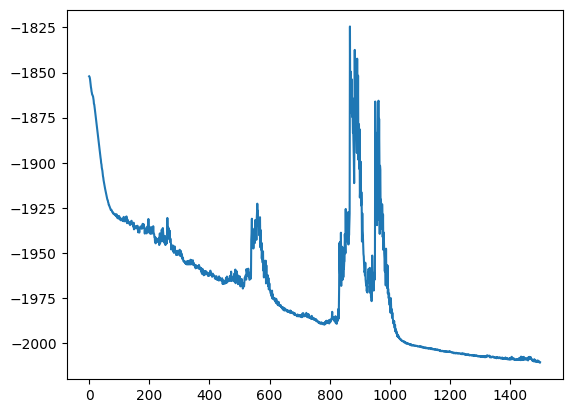

In [34]:
plt.plot(loss_hist)
plt.show()

In [35]:
samples_z = model_seq.HMC(qz, num_burnin_steps=250, num_results=750).all_states

Sampling took 124.6s


In [36]:
samples = prob_model.bij.forward(list(samples_z.T))

In [37]:
packed_samples = jnp.stack(prob_model.pack_bij.inverse(samples), axis=-1)

In [38]:
rhat = tfp.mcmc.potential_scale_reduction(jnp.transpose(packed_samples, (1,2,0,3)), independent_chain_ndims=2)
rhat = prob_model.pack_bij.forward(list(rhat.T))

In [45]:
rhat['lens_mass']

{'1': {'gamma2': Array(1.0060592, dtype=float32),
  'gamma1': Array(1.0029953, dtype=float32)},
 '0': {'theta_E': Array(1.0048484, dtype=float32),
  'gamma': Array(1.0118922, dtype=float32),
  'e2': Array(1.0035353, dtype=float32),
  'e1': Array(1.0009881, dtype=float32)}}

In [44]:
rhat['source_light']['1']['z_source']

Array(1.1927143, dtype=float32)

In [46]:
rhat['cosmo']

{'w0': Array(1.0588845, dtype=float32), 'Om0': Array(1.1227024, dtype=float32)}

In [54]:
def flatten_samples(samples, components=('lens_mass', 'cosmo', 'redshift')):
    flat_samples = []
    labels = []
    for k0 in components:
        if k0 == 'redshift':
            k0 = 'source_light'
            k2 = 'z_source'
            ds = samples.get(k0, {})
            for k1 in sorted(ds.keys()):
                if k2 in samples[k0][k1]:
                    flat_samples.append(np.asarray(samples[k0][k1][k2].flatten()))
                    labels.append(f"{k2}_{k1}")
        else:
            ds = samples.get(k0, {})
            for k1 in sorted(ds.keys()):
                if k0 != 'cosmo':
                    for k2 in sorted(ds[k1].keys()):
                        flat_samples.append(np.asarray(samples[k0][k1][k2].flatten()))
                        labels.append(f"{k2}_{k1}")
                else:
                    flat_samples.append(np.asarray(samples[k0][k1].flatten()))
                    labels.append(k1)
    return np.stack(flat_samples), labels


def corner_plot(samples, sigma_levels=np.array([1., 2., 3.]), components=('lens_mass', 'cosmo', 'redshift')):
    corner_samples, labels = flatten_samples(samples, components=components)

    figure = corner(corner_samples.T, bins=20, range=np.ones(len(labels)) * 0.999,
                    plot_datapoints=False, plot_density=False,
                    fill_contours=True, show_titles=True,
                    quantiles=[0.16, 0.50, 0.84],
                    levels=(1.0 - np.exp(-0.5 * sigma_levels ** 2)),
                    labels=labels,
                    title_fmt=".2e"
                    )
    return figure


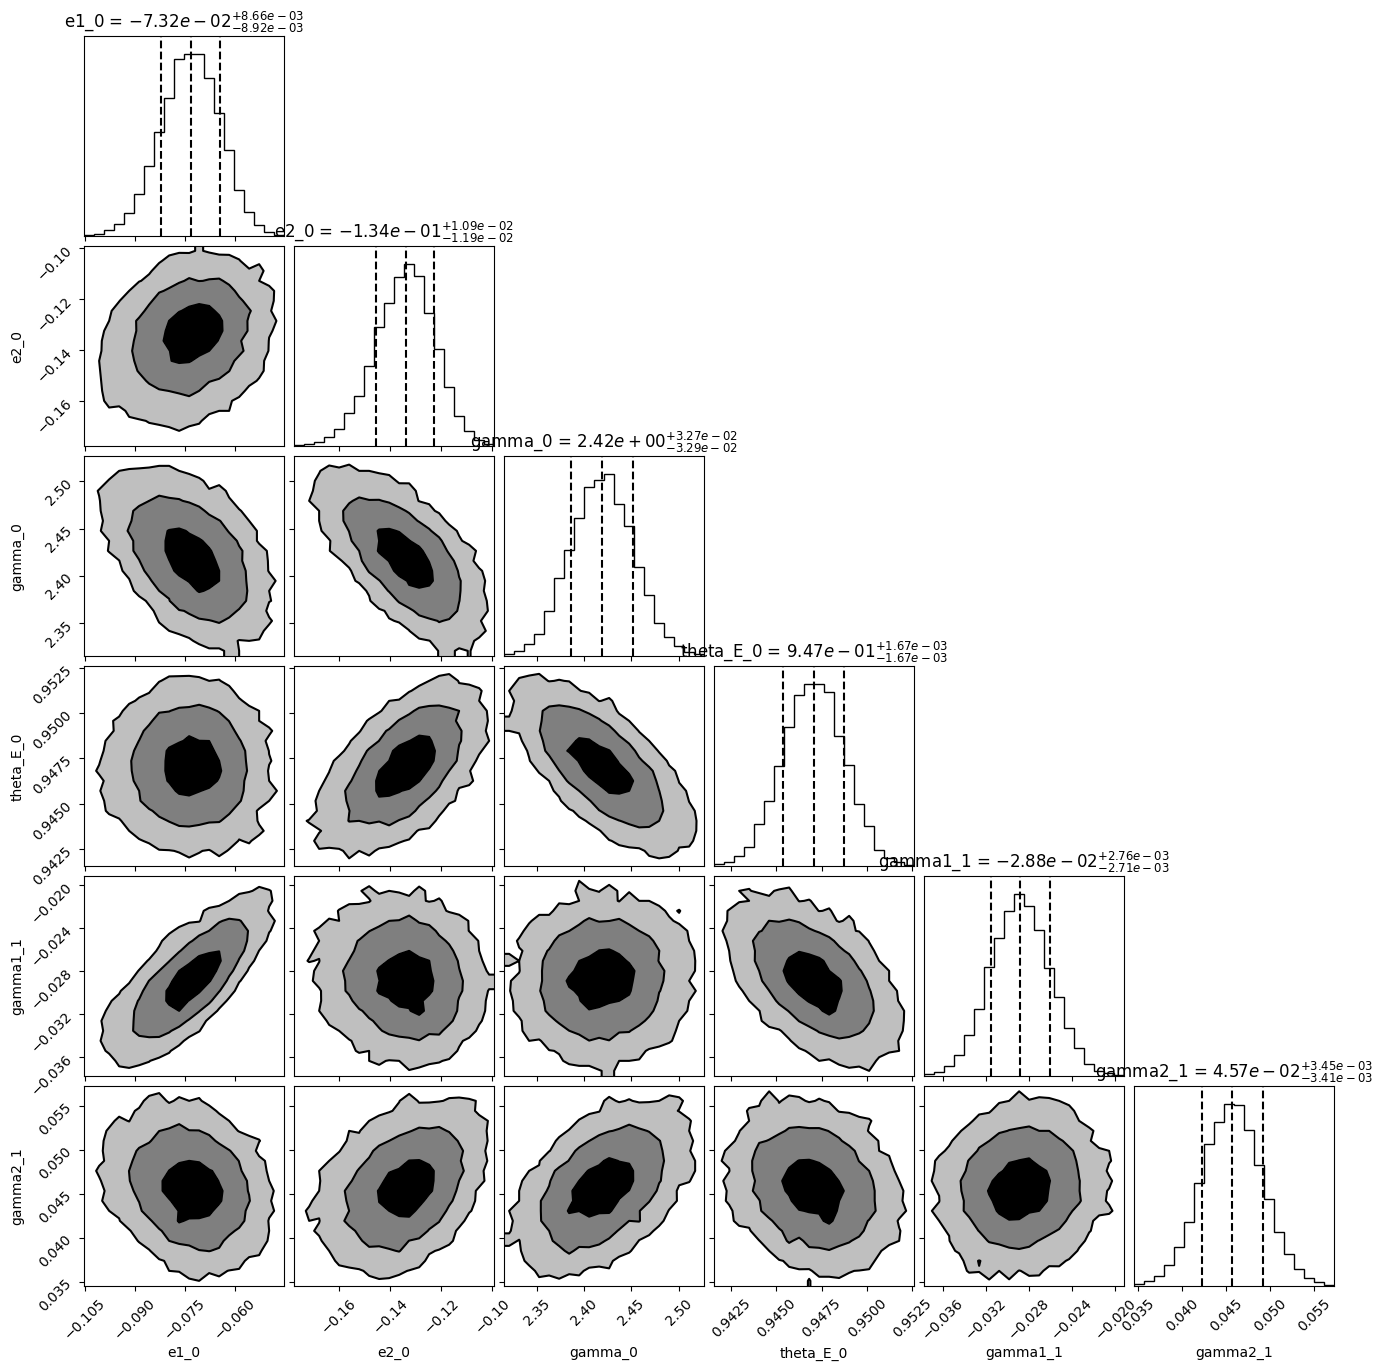

In [55]:
_ = corner_plot(samples, components=('lens_mass',))

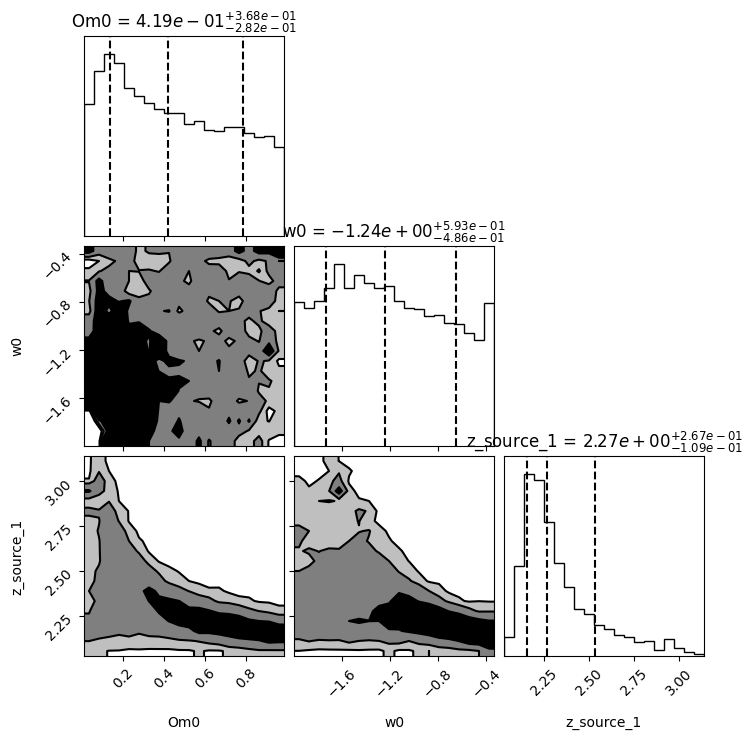

In [56]:
_ = corner_plot(samples, components=('cosmo', 'redshift'))

In [57]:
z_s2_truth

2.3

## Masking

You can mask unwanted foreground components by using a binary mask: a matrix with the same shape as the observed image with `True` values in the pixels you want to include, and `False` in pixels you want to exclude. You can pass it to the `ForwardProbModel` (or `BackwardProbModel`) class as a kward argument:

```python
prob_model = ForwardProbModel(
    prior,
    observed_img,
    mask=mask,
    background_rms=bkg_rms,
    exp_time=exp_time,
    include_pixels=True,
    include_positions=False
)
```